In [62]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, summarize_results

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions
import utils.results as results
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [63]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [64]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [65]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using cuda device


100%|██████████| 100/100 [00:00<00:00, 309.02it/s]


Final training loss: 0.2257750779390335
Final validation loss: 0.580865740776062
Final validation R^2: 0.2278537998562249


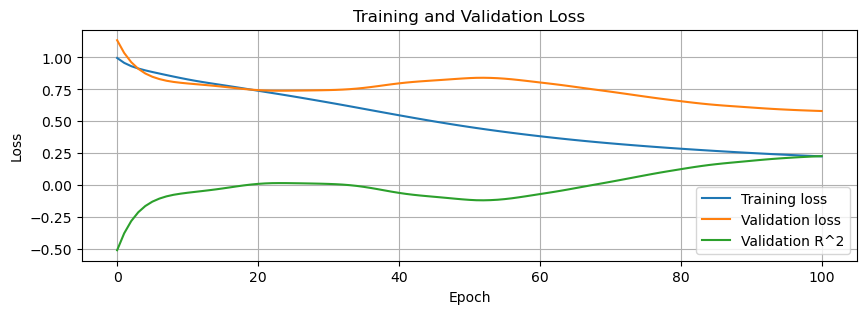

In [66]:
model, training_loss, validation_loss, validation_r_squared = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=5e-4, 
                                                                       weight_decay=1e-1, 
                                                                       verbose=True,
                                                                       seed=SEED)

In [67]:
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [68]:
interactive_plot_predictions(
    country_valid=preprocessor.country_valid,
    y_valid=y_valid,
    y_pred_mean=y_pred,
    y_pred_median=None,
    y_pred_best=None,
    y_pred_std=None,
    title_prefix="GDP Prediction: "
)

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

In [69]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [70]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Smoothing

In [71]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from utils.results import compute_rsquared
from torch.nn import MSELoss

class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.LayerNorm(300),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        if len(x.shape) == 3:  # Training: input shape (batch_size, 5, 180)
            batch_size, num_samples, num_features = x.size()
            x = x.view(batch_size * num_samples, num_features)
            output = self.linear_relu_stack(x)
            output = output.view(batch_size, num_samples, -1)  # Reshape back to (batch_size, 5, 1)
        elif len(x.shape) == 2:  # Validation: input shape (batch_size, 180)
            output = self.linear_relu_stack(x)
            # output = output.view(x.size(0), 1, -1)  # Reshape to (batch_size, 1, 1) for consistency
        else:
            raise ValueError("Input shape not supported!")
        return output
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations

def get_device(verbose = False):
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    if verbose:
        print(f"Using {device} device")
    return device
    
def custom_train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3, custom_loss = MSELoss(), seed = 42, verbose = True):
    set_seed(seed)

    device = get_device(verbose)

    num_features = x_train.shape[-1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = custom_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    valid_r_squared = []
    mse_losses = []
    
    epoch_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    for t in epoch_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        y_pred_valid = model(x_valid_t)
        loss_valid = loss_fn(y_pred_valid, y_valid_t)
        model.train()

        r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())

        valid_r_squared.append(r_squared)
        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        mse_train = torch.linalg.norm(y_pred[:,4,:] - y_train_t, ord=2).item() / y_train_t.size(0)
        mse_valid = torch.linalg.norm(y_pred_valid - y_valid_t, ord=2).item() / y_valid_t.size(0)
        mse_losses.append([mse_train, mse_valid])

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred_valid = model(x_valid_t)

    v_loss = loss_fn(y_pred_valid, y_valid_t)
    validation_loss.append(v_loss.item())

    y_pred_train = model(x_train_t)
    t_loss = loss_fn(y_pred_train, y_train_t)
    training_loss.append(t_loss.item())

    r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
    valid_r_squared.append(r_squared)

    mse_train = torch.linalg.norm(y_pred_train[:,4,:] - y_train_t, ord=2).item() / y_train_t.size(0)
    mse_valid = torch.linalg.norm(y_pred_valid - y_valid_t, ord=2).item() / y_valid_t.size(0)
    mse_losses.append([mse_train, mse_valid])

    if verbose:
        print(f"Final training loss: {t_loss.item()}")
        print(f"Final validation loss: {v_loss.item()}")
        print(f"Final validation R^2: {r_squared}")

        plt.figure(figsize=(10, 3))
        plt.plot(training_loss, label="Training loss")
        plt.plot(validation_loss, label="Validation loss")
        plt.plot(valid_r_squared, label="Validation R^2")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.grid()
        plt.legend()
        plt.show()

    
    return model, training_loss, validation_loss, valid_r_squared, mse_losses

In [72]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

In [73]:
batches = []
countries = []
dates = []
y_augmented_train = []
for country in df_x_train['country'].unique():
    country_data = df_x_train[df_x_train['country'] == country]
    
    for date_data in country_data.iterrows():
        date = date_data[1]['date']

        prev_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date - pd.DateOffset(months=1))]
        snd_prev_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date - pd.DateOffset(months=2))]
        third_prev_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date - pd.DateOffset(months=3))]
        fourth_prev_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date - pd.DateOffset(months=4))]
        
        if len(snd_prev_hf) == 0 or len(prev_hf) == 0 or len(third_prev_hf) == 0 or len(fourth_prev_hf) == 0:
            print("Skipping", country, date)
            continue

        if len(snd_prev_hf) > 1 or len(prev_hf) > 1 or len(third_prev_hf) > 1 or len(fourth_prev_hf) > 1:
            print("Warning too big", country, date)
            continue

        batch = []
        
        batch.append(fourth_prev_hf['data'].values[0].astype(np.float32))
        batch.append(third_prev_hf['data'].values[0].astype(np.float32))
        batch.append(snd_prev_hf['data'].values[0].astype(np.float32))
        batch.append(prev_hf['data'].values[0].astype(np.float32))
        batch.append(date_data[1]['data'].astype(np.float32))

        dates.append(date)
        countries.append(country)
        y_augmented_train.append(date_data[1]['true'])

        batches.append(batch)

countries = np.array(countries)
dates = np.array(dates)
y_augmented_train = np.array(y_augmented_train)
augmented_data = np.array(batches)

Skipping Canada 2006-03-01 00:00:00
Skipping Canada 2006-03-01 00:00:00
Skipping Canada 2006-03-01 00:00:00
Skipping Canada 2006-03-01 00:00:00
Skipping Germany 2006-03-01 00:00:00
Skipping Germany 2006-03-01 00:00:00
Skipping Germany 2006-03-01 00:00:00
Skipping Germany 2006-03-01 00:00:00
Skipping Korea 2006-03-01 00:00:00
Skipping Korea 2006-03-01 00:00:00
Skipping Korea 2006-03-01 00:00:00
Skipping Korea 2006-03-01 00:00:00
Skipping Switzerland 2006-03-01 00:00:00
Skipping Switzerland 2006-03-01 00:00:00
Skipping Switzerland 2006-03-01 00:00:00
Skipping Switzerland 2006-03-01 00:00:00
Skipping United Kingdom 2006-03-01 00:00:00
Skipping United Kingdom 2006-03-01 00:00:00
Skipping United Kingdom 2006-03-01 00:00:00
Skipping United Kingdom 2006-03-01 00:00:00
Skipping United States 2006-03-01 00:00:00
Skipping United States 2006-03-01 00:00:00
Skipping United States 2006-03-01 00:00:00
Skipping United States 2006-03-01 00:00:00


In [74]:
def smoothness_loss(y_pred, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    if y_pred.shape[1] > 1:
        # Compute the loss related to smoothness
        smoothness_loss_ord1 = 0
        for i in range(1, 4):
            # Divide by 3 because dt is 1/3 month, and by 4 because we have 4 time points and we average them
            smoothness_loss_ord1 += torch.linalg.norm((y_pred[:, i, :] - y_pred[:, i - 1, :])) ** 2 / (3 * 4 * y_pred.shape[0])

        # Constraint on the double derivative
        smoothness_loss_ord2 = 0
        for i in range(2, 4):
            smoothness_loss_ord2 += torch.linalg.norm(y_pred[:, i, :] - 2 * y_pred[:, i - 1, :] + y_pred[:, i - 2, :]) ** 2 / (3 * 4 * y_pred.shape[0])

        return smoothness_loss_ord1 * smoothness_weight_ord1 + smoothness_loss_ord2 * smoothness_weight_ord2

    else:
        raise ValueError("Input shape not supported!")

def custom_loss(y_pred, y_true, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    # Compute usual MSE on actual GDP values
    mse = MSELoss()

    if y_pred.shape[1] > 1:
        prediction_loss = mse(y_pred[:, 4, :], y_true)  # First column is the actual GDP

        smooth_loss = smoothness_loss(y_pred, smoothness_weight_ord1, smoothness_weight_ord2)

        return prediction_loss + smooth_loss
    elif y_pred.shape[1] == 1:
        return mse(y_pred, y_true)
    else:
        raise ValueError("Input shape not supported!")

In [75]:
np.logspace(-1, 2, 15)

array([  0.1       ,   0.16378937,   0.26826958,   0.43939706,
         0.71968567,   1.17876863,   1.93069773,   3.16227766,
         5.17947468,   8.48342898,  13.89495494,  22.75845926,
        37.2759372 ,  61.05402297, 100.        ])

In [76]:
training_losses = []
validation_losses = []
validation_r_squareds = []
smoothness_weights = np.logspace(-1, 2, 15)
smoothness_losses = []
global_mse_losses = []
parameters = []

for ord1_weight in tqdm(smoothness_weights):
    for ord2_weight in smoothness_weights:
        model, training_loss, validation_loss, validation_r_squared, mse_loss = custom_train_nn(augmented_data, 
                                                                            y_augmented_train, 
                                                                            X_valid, 
                                                                            y_valid, 
                                                                            num_epochs=100, 
                                                                            learning_rate=5e-4, 
                                                                            weight_decay=5e-2, 
                                                                            verbose=False,
                                                                            custom_loss=lambda x, y: custom_loss(x, y, ord1_weight, smoothness_weight_ord2=ord2_weight),
                                                                            seed=SEED)
        parameters.append((ord1_weight, ord2_weight))
        training_losses.append(training_loss)
        validation_losses.append(validation_loss)
        validation_r_squareds.append(validation_r_squared)
        global_mse_losses.append(mse_loss)

        y_pred_hf = model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()

        df_preds = pd.DataFrame({
            'date': preprocessor.dates_high_freq,
            'country': preprocessor.country_high_freq,
            'data': [y_pred_hf[i] for i in range(len(x_hf))]
        })

        smoothness_values = []
        for country in df_preds['country'].unique():
            country_data = df_preds[df_preds['country'] == country]
            
            smoothness_values_per_func = []
            for smoothness_func in results.all_smoothness_metrics:
                smoothness_values_per_func.append(smoothness_func(country_data['data'].values))

            smoothness_values.append(smoothness_values_per_func)

        smoothness_values = np.array(smoothness_values)

        # Store different means of the smoothness values
        smoothness_losses.append([np.mean(smoothness_values), np.expm1(np.mean(np.log1p(smoothness_values))), len(smoothness_values) / np.sum(1 / smoothness_values)])

  0%|          | 0/15 [00:00<?, ?it/s]

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_heatmap_top_filtered_percent(data, x_vals, y_vals, title, xlabel, ylabel, cmap='viridis', threshold=5):
    # Compute the 90th percentile threshold
    valid_data = data[np.isfinite(data)]
    if len(valid_data) == 0:
        print("No valid data to plot.")
        return
    #threshold = np.percentile(valid_data, 90)
    
    # Mask values below the threshold
    data_filtered = np.where((data >= -threshold) & (data <= threshold), data, np.nan)
    
    im = plt.imshow(data_filtered, origin='lower', 
                    extent=[min(x_vals), max(x_vals), min(y_vals), max(y_vals)], 
                    aspect='auto', cmap=cmap) #, norm=norm)
    cbar = plt.colorbar(im)
    cbar.set_label('Metric Value')
    plt.title(title + f' (Between -{threshold} and {threshold})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.yscale('log')


In [78]:
mse_loss[-1]

[0.014924942225149932, 0.11293298793288897]

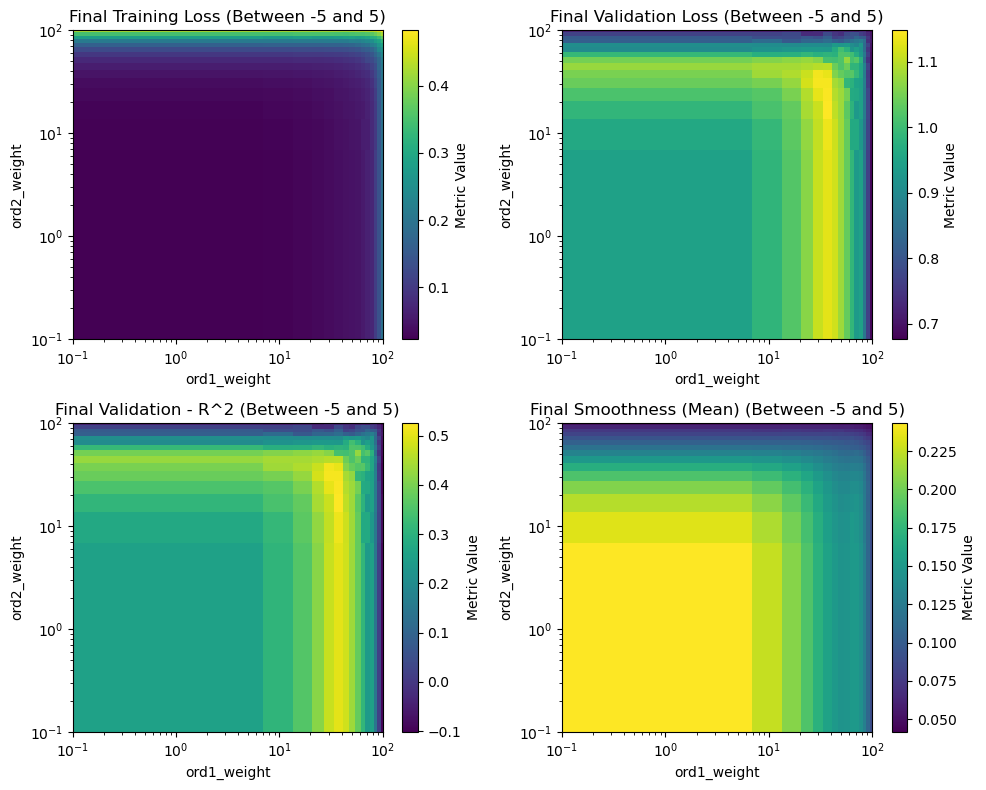

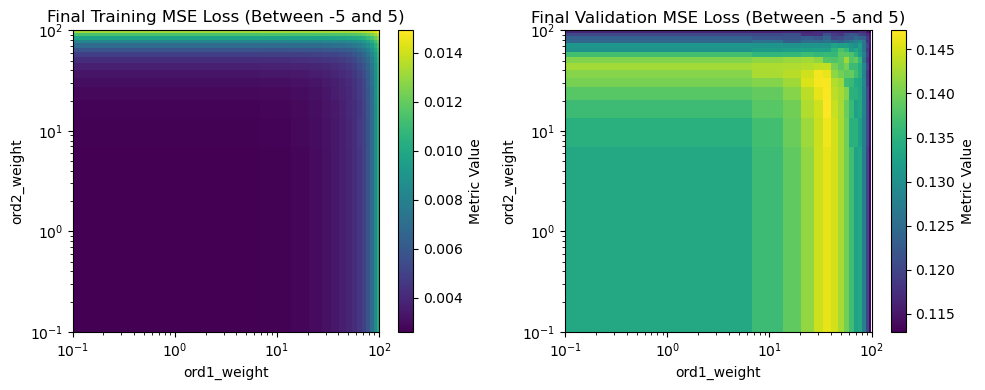

In [79]:
N = len(smoothness_weights)

# Create mapping from (ord1_weight, ord2_weight) to grid indices
ord1_to_idx = {w: i for i, w in enumerate(smoothness_weights)}
ord2_to_idx = {w: i for i, w in enumerate(smoothness_weights)}

# Initialize empty arrays for final metrics
final_train_loss = np.zeros((N, N))
final_val_loss = np.zeros((N, N))
final_val_r2 = np.zeros((N, N))
final_smoothness_mean = np.zeros((N, N))
final_validation_mse_loss = np.zeros((N, N))  # example if needed
final_training_mse_loss = np.zeros((N, N))  # example if needed

for (ord1, ord2), tr_loss, val_loss, val_r2, mse_loss, sm_loss in zip(parameters, 
                                                                    training_losses, 
                                                                    validation_losses, 
                                                                    validation_r_squareds, 
                                                                    global_mse_losses, 
                                                                    smoothness_losses):
    i = ord1_to_idx[ord1]
    j = ord2_to_idx[ord2]

    final_train_loss[i, j] = tr_loss[-1] if len(tr_loss) > 0 else np.nan
    final_val_loss[i, j] = val_loss[-1] if len(val_loss) > 0 else np.nan
    final_val_r2[i, j] = val_r2[-1] if len(val_r2) > 0 else np.nan
    
    final_smoothness_mean[i, j] = sm_loss[1] if len(sm_loss) > 0 else np.nan
    final_validation_mse_loss[i, j] = mse_loss[-1][1] if len(mse_loss) > 0 else np.nan
    final_training_mse_loss[i, j] = mse_loss[-1][0] if len(mse_loss) > 0 else np.nan

plt.figure(figsize=(10, 8))

# Plot final training loss
plt.subplot(2, 2, 1)
plot_heatmap_top_filtered_percent(final_train_loss, smoothness_weights, smoothness_weights, 
             title='Final Training Loss', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')

plt.subplot(2, 2, 2)
# Example usage with final_validation_loss (or any other metric you computed):
plot_heatmap_top_filtered_percent(final_val_loss, smoothness_weights, smoothness_weights, 
                            title='Final Validation Loss', 
                            xlabel='ord1_weight', 
                            ylabel='ord2_weight')

plt.subplot(2, 2, 3)
plot_heatmap_top_filtered_percent(-final_val_r2, smoothness_weights, smoothness_weights, 
             title='Final Validation - R^2', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')

# Plot final smoothness mean metric
plt.subplot(2, 2, 4)
plot_heatmap_top_filtered_percent(final_smoothness_mean, smoothness_weights, smoothness_weights, 
             title='Final Smoothness (Mean)', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_heatmap_top_filtered_percent(final_training_mse_loss, smoothness_weights, smoothness_weights, 
             title='Final Training MSE Loss', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')

plt.subplot(1, 2, 2)
plot_heatmap_top_filtered_percent(final_validation_mse_loss, smoothness_weights, smoothness_weights, 
             title='Final Validation MSE Loss', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')
plt.tight_layout()
plt.show()


Using cuda device


  0%|          | 0/100 [00:00<?, ?it/s]

Final training loss: 0.05094446986913681
Final validation loss: 0.9461804032325745
Final validation R^2: -0.25775966926474037


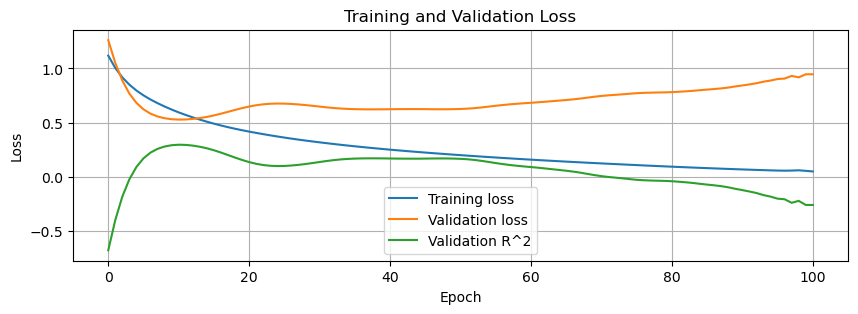

In [80]:
smoothness_weight_ord1=0.1
smoothness_weight_ord2=10
model, training_loss, validation_loss, validation_r_squared, global_mse_losses = custom_train_nn(augmented_data, 
                                                                        y_augmented_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=5e-4, 
                                                                        weight_decay=5e-2, 
                                                                        verbose=True,
                                                                        custom_loss=lambda x, y: custom_loss(x, y, smoothness_weight_ord1, smoothness_weight_ord2),
                                                                        seed=SEED)

In [81]:
device = get_device(False)

# Get the predictions
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()
y_pred_hf = model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()

In [82]:

# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])
predictions_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'y_pred': y_pred_hf,
    'Set': 'High Frequency'
})


# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

predictions_hf_melted = predictions_hf.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    filtered_data_hf = predictions_hf_melted[predictions_hf_melted["country"] == selected_country]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data_hf,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True, palette="Set3"
    )
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

In [83]:
# Batch preds
pred_batches = []

df_preds = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [y_pred_hf[i] for i in range(len(x_hf))]
})

for country in df_preds['country'].unique():
    country_data = df_preds[df_preds['country'] == country]
    
    for date_data in country_data.iterrows():
        date = date_data[1]['date']

        prev_hf = df_preds[(df_preds['country'] == country) & (df_preds['date'] == date - pd.DateOffset(months=1))]
        snd_prev_hf = df_preds[(df_preds['country'] == country) & (df_preds['date'] == date - pd.DateOffset(months=2))]
        third_prev_hf = df_preds[(df_preds['country'] == country) & (df_preds['date'] == date - pd.DateOffset(months=3))]
        fourth_prev_hf = df_preds[(df_preds['country'] == country) & (df_preds['date'] == date - pd.DateOffset(months=4))]
        
        if len(snd_prev_hf) == 0 or len(prev_hf) == 0 or len(third_prev_hf) == 0 or len(fourth_prev_hf) == 0:
            #print("Skipping", country, date)
            continue

        if len(snd_prev_hf) > 1 or len(prev_hf) > 1 or len(third_prev_hf) > 1 or len(fourth_prev_hf) > 1:
            print("Warning too big", country, date)
            continue

        batch = []
        
        batch.append(fourth_prev_hf['data'].values[0].astype(np.float32))
        batch.append(third_prev_hf['data'].values[0].astype(np.float32))
        batch.append(snd_prev_hf['data'].values[0].astype(np.float32))
        batch.append(prev_hf['data'].values[0].astype(np.float32))
        batch.append(date_data[1]['data'])

        pred_batches.append(batch)

In [84]:
pred_batched = np.array(pred_batches).reshape(-1, 5, 1)
pred_batched = torch.tensor(pred_batched, dtype=torch.float32).to(device)
# smooth_loss = smoothness_loss(pred_batched, smoothness_weight_ord1, smoothness_weight_ord2)
smoothness_loss(pred_batched, 0, 1), smoothness_loss(pred_batched, 1, 0)

(tensor(0.0192, device='cuda:0'), tensor(0.0252, device='cuda:0'))

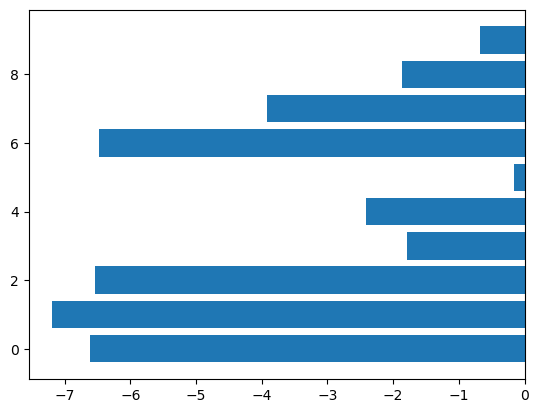

In [85]:
# Compute per country
smoothness_values = []
for country in df_preds['country'].unique():
    country_data = df_preds[df_preds['country'] == country]
    
    smoothness_values_per_func = []
    for smoothness_func in results.all_smoothness_metrics:
        smoothness_values_per_func.append(smoothness_func(country_data['data'].values))

    smoothness_values.append(smoothness_values_per_func)

smoothness_values = np.array(smoothness_values)

plt.barh(range(smoothness_values.shape[1]), np.log(smoothness_values.mean(axis=0)))
plt.show()

In [86]:
np.mean(smoothness_values), np.exp(np.mean(np.log(smoothness_values))), len(smoothness_values) / np.sum(1 / smoothness_values)

(0.18010980325502315, 0.02070812395779279, 0.00026028870603900706)

### Case Study: Fourrier Transform Smoothing

c:\Users\sebge\miniconda3\envs\epfl\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sebge\miniconda3\envs\epfl\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


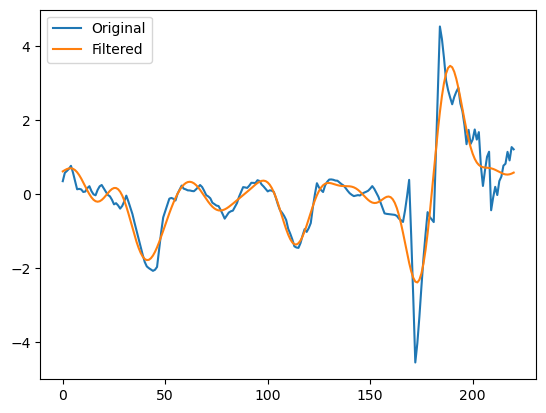

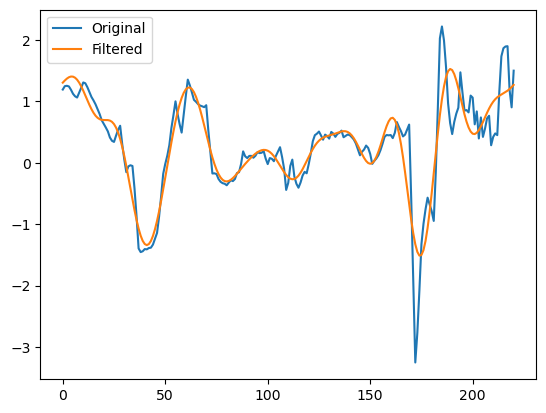

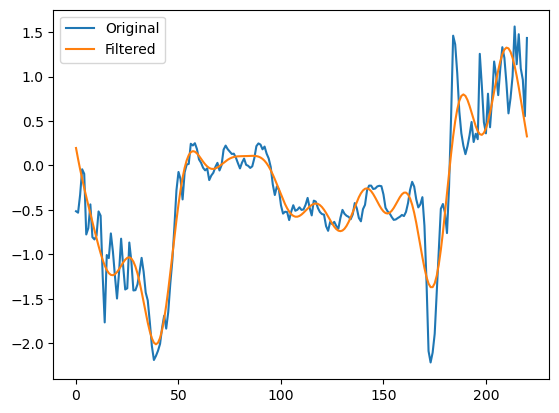

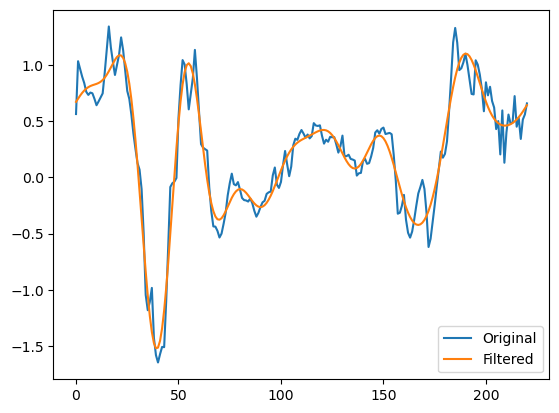

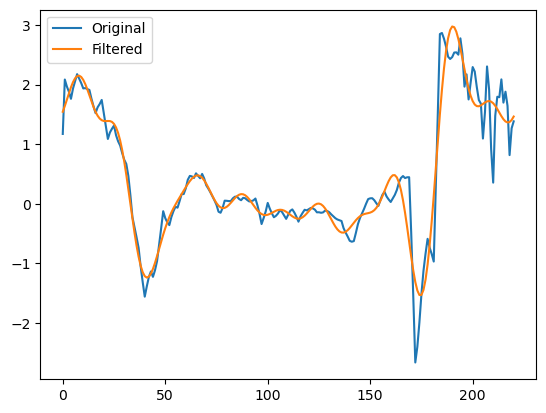

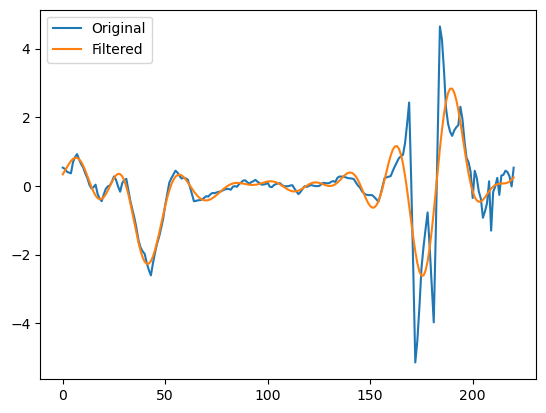

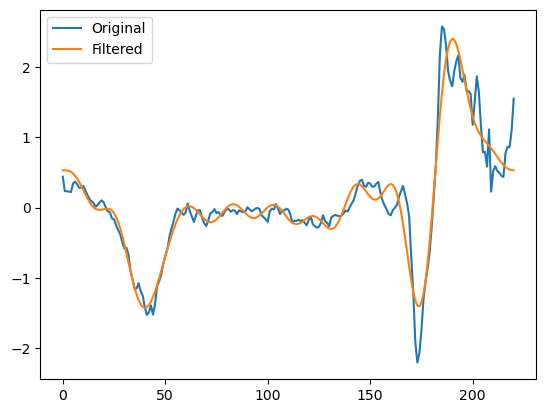

In [87]:
def fft_analysis(preds, cutoff=0.05): 
    fft = np.fft.fft(preds)
    freqs = np.fft.fftfreq(len(preds))

    filtered = np.copy(fft)
    filtered[np.abs(freqs) > cutoff] = 0

    y_filtered = np.fft.ifft(filtered)
    plt.plot(preds, label='Original')
    plt.plot(y_filtered, label='Filtered')
    plt.legend()
    plt.show()

# Per country
for country in df_preds['country'].unique():
    country_data = df_preds[df_preds['country'] == country]
    fft_analysis(country_data['data'].values)